Importing the libraries

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf

from transformers import AutoImageProcessor, TFEfficientFormerModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet,VGG16,ResNet50,EfficientNetB0
from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix,classification_report

import matplotlib.pyplot as plt

d:\AnaConda\envs\Cap\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Image Parameters

In [2]:
image_size = (224, 224)  # Adjust according to the input size expected by the chosen model
batch_size = 32
test_split = 0.1
validation_split = 0.2

In [3]:
data_dir = '../Data/Image_set2/ELA_images/train'

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=validation_split,
    data_format = 'channels_first'
)

In [5]:
generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

# Split the data into training, validation, and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    generator.filepaths,
    generator.labels.astype(str),  # Convert labels to strings
    test_size=test_split,
    random_state=42
)

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images,
    train_labels,
    test_size=validation_split,
    random_state=42
)

Found 29736 images belonging to 2 classes.


In [6]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filepath': train_images, 'class': train_labels}),
    x_col='filepath',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filepath': val_images, 'class': val_labels}),
    x_col='filepath',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filepath': test_images, 'class': test_labels}),
    x_col='filepath',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)

Found 17128 validated image filenames belonging to 2 classes.
Found 1070 validated image filenames belonging to 2 classes.
Found 2974 validated image filenames belonging to 2 classes.


Vision Transformer Model

In [8]:
effmodel = TFEfficientFormerModel.from_pretrained("snap-research/efficientformer-l1-300")

Some layers from the model checkpoint at snap-research/efficientformer-l1-300 were not used when initializing TFEfficientFormerModel: ['distillation_classifier', 'classifier']
- This IS expected if you are initializing TFEfficientFormerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFEfficientFormerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFEfficientFormerModel were initialized from the model checkpoint at snap-research/efficientformer-l1-300.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFEfficientFormerModel for predictions without further training.


In [9]:
for layer in effmodel.layers:
    layer.trainable = False


In [10]:
model = Sequential()
model.add(effmodel)
model.add(Lambda(lambda x: x['last_hidden_state']))
model.add(GRU(units=64, return_sequences=False))  # Add GRU layer here
model.add(Dense(64, activation='gelu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

In [11]:
model.compile(loss="BinaryCrossentropy",optimizer="adam",metrics=["accuracy"])

In [12]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
history=model.fit(train_generator, epochs=100, validation_data=val_generator)

Epoch 1/100
536/536 [==============================] - 116s 216ms/step - loss: 0.3362 - accuracy: 0.8563 - val_loss: 0.4167 - val_accuracy: 0.8121
Epoch 2/100
536/536 [==============================] - 113s 210ms/step - loss: 0.3150 - accuracy: 0.8686 - val_loss: 0.4475 - val_accuracy: 0.8047
Epoch 3/100
536/536 [==============================] - 113s 211ms/step - loss: 0.3181 - accuracy: 0.8650 - val_loss: 0.4133 - val_accuracy: 0.8168
Epoch 4/100
536/536 [==============================] - 112s 209ms/step - loss: 0.3098 - accuracy: 0.8690 - val_loss: 0.4182 - val_accuracy: 0.8121
Epoch 5/100
536/536 [==============================] - 114s 213ms/step - loss: 0.3051 - accuracy: 0.8710 - val_loss: 0.3974 - val_accuracy: 0.8131
Epoch 6/100
536/536 [==============================] - 114s 213ms/step - loss: 0.2923 - accuracy: 0.8782 - val_loss: 0.4266 - val_accuracy: 0.8252
Epoch 7/100
536/536 [==============================] - 114s 212ms/step - loss: 0.2813 - accuracy: 0.8826 - val_loss: 0

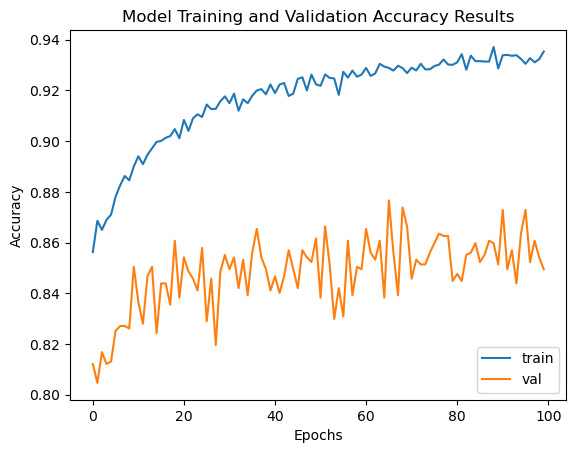

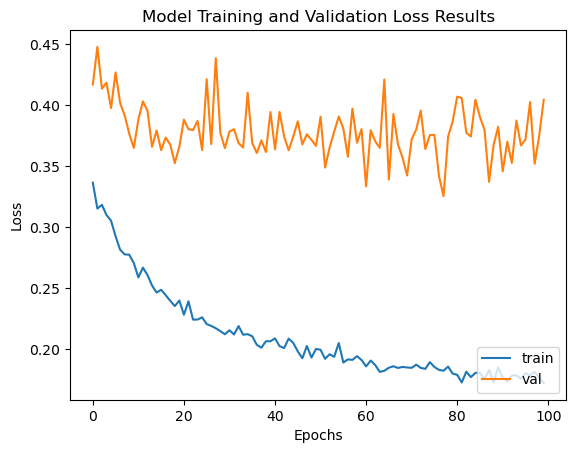

In [18]:
plot(history, "Model")

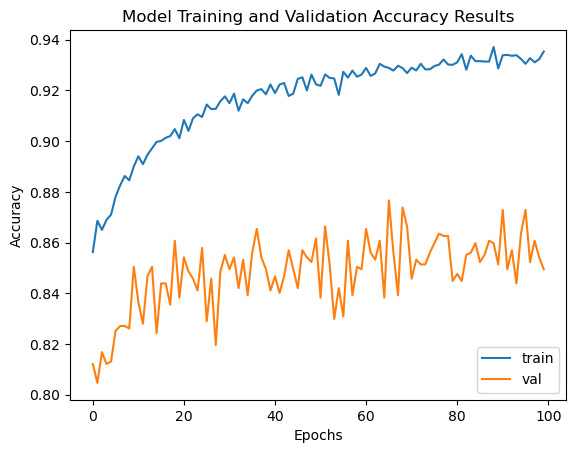

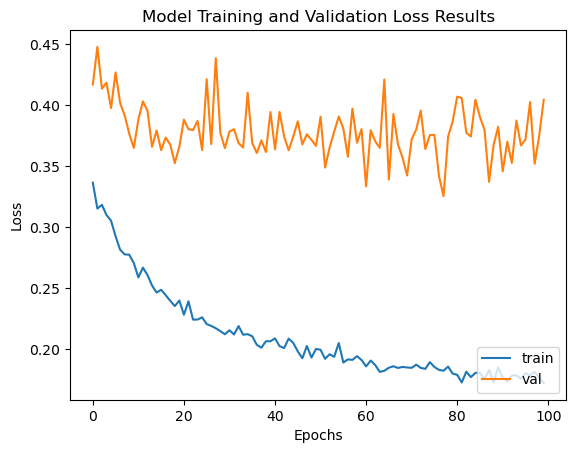

In [17]:
plot(history, "Model")

In [94]:
pred=model.predict(test_generator)

93/93 [==============================] - 10s 95ms/step


In [95]:
pred

array([[0.41251552, 0.58164454],
       [0.9981851 , 0.00173145],
       [0.9924981 , 0.00755122],
       ...,
       [0.00642743, 0.99361223],
       [0.04611257, 0.95447755],
       [0.98883086, 0.01087322]], dtype=float32)

In [110]:
predictions=[]
for lis in pred:
    if lis[0]>=lis[1]:
        predictions.append(0.0)
    else:
        predictions.append(1.0)

In [25]:
testlabels=[]
for i in test_labels:
    testlabels.append(float(i))

In [106]:
import sklearn

In [112]:
confusion_matrix(predictions, testlabels)

array([[1181,  247],
       [ 348, 1198]], dtype=int64)

In [129]:
print(classification_report(predictions,testlabels))

              precision    recall  f1-score   support

         0.0       0.77      0.83      0.80      1428
         1.0       0.83      0.77      0.80      1546

    accuracy                           0.80      2974
   macro avg       0.80      0.80      0.80      2974
weighted avg       0.80      0.80      0.80      2974



In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_efficient_former_model (  TFBaseModelOutput(last_h  11426249 
 TFEfficientFormerModel)     idden_state=(None, None,            
                              448),                              
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 lambda (Lambda)             (None, None, 448)         0         
                                                                 
 gru (GRU)                   (None, 64)                98688     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout_15 (Dropout)        (None, 256)               0

Plotting Vision Transformer Model

In [16]:
def plot(history, name):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend(['train', 'val'], loc = "lower right")
    plt.title(name + " Training and Validation Accuracy Results")
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend(['train', 'val'], loc = "lower right")
    plt.title(name + " Training and Validation Loss Results")
    plt.show()

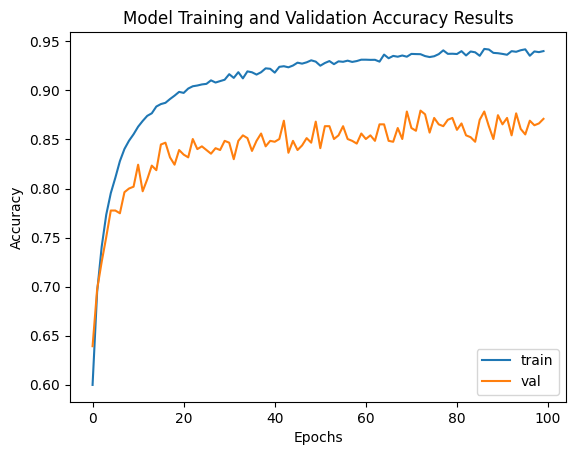

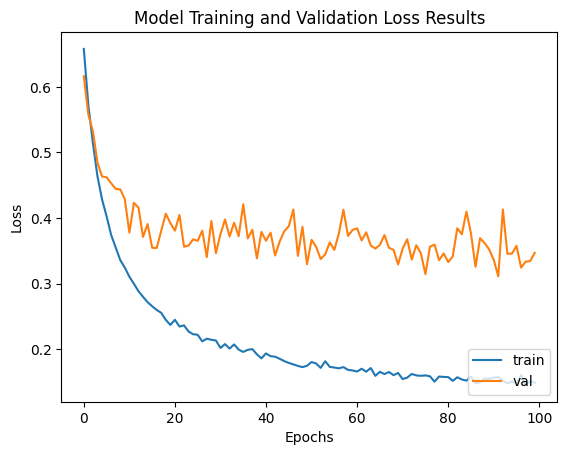

In [21]:
plot(history, "Model")

In [25]:
model.save("first.h5")

MobileNet Model

In [44]:
# Load MobileNet model with pre-trained weights (exclude top layers)
base_model = MobileNet(weights='imagenet', include_top=False)

# Create a Sequential model
model = Sequential()

# Add MobileNet base model to the Sequential model
model.add(base_model)

# Add GlobalAveragePooling2D layer to reduce dimensionality
model.add(GlobalAveragePooling2D())

# Add a Dense layer (or more) for classification
model.add(GRU(units=64, return_sequences=False))  # Add GRU layer here
model.add(Dense(64, activation='gelu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))  # num_classes is the number of output classes

# Freeze MobileNet layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
mobile_hist=model.fit(train_generator,epochs=10,validation_data=val_generator)

Epoch 1/10
536/536 [==============================] - 103s 190ms/step - loss: 0.6589 - accuracy: 0.6262 - val_loss: 0.6037 - val_accuracy: 0.6673
Epoch 2/10
536/536 [==============================] - 112s 209ms/step - loss: 0.5963 - accuracy: 0.6725 - val_loss: 0.5919 - val_accuracy: 0.6776
Epoch 3/10
536/536 [==============================] - 107s 199ms/step - loss: 0.5793 - accuracy: 0.6903 - val_loss: 0.5793 - val_accuracy: 0.6841
Epoch 4/10
536/536 [==============================] - 107s 199ms/step - loss: 0.5670 - accuracy: 0.6994 - val_loss: 0.5757 - val_accuracy: 0.6804
Epoch 5/10
536/536 [==============================] - 101s 188ms/step - loss: 0.5584 - accuracy: 0.7015 - val_loss: 0.5653 - val_accuracy: 0.6916
Epoch 6/10
536/536 [==============================] - 116s 216ms/step - loss: 0.5610 - accuracy: 0.7042 - val_loss: 0.5744 - val_accuracy: 0.6916
Epoch 7/10
536/536 [==============================] - 126s 236ms/step - loss: 0.5569 - accuracy: 0.7069 - val_loss: 0.6037 -

In [47]:
mpred=model.predict(test_generator)

93/93 [==============================] - 17s 181ms/step


In [48]:
pred=[]
for i in mpred:
    if i[0]>=i[1]:
        pred.append(0)
    else:
        pred.append(1)
print(confusion_matrix(testlabels,pred))
print(classification_report(testlabels,pred))

[[1177  352]
 [ 478  967]]
              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74      1529
         1.0       0.73      0.67      0.70      1445

    accuracy                           0.72      2974
   macro avg       0.72      0.72      0.72      2974
weighted avg       0.72      0.72      0.72      2974



In [15]:
model.save("../Model/mobilenet.h5")

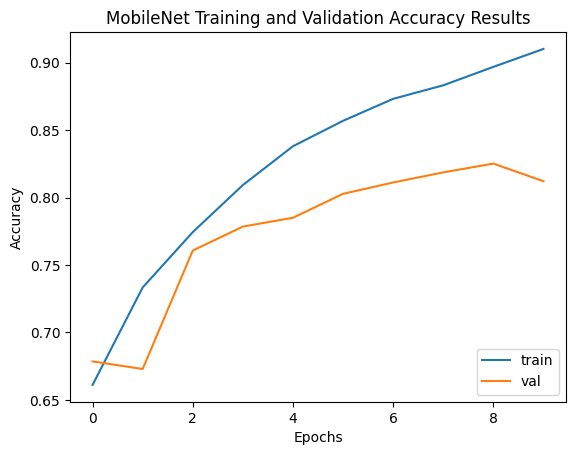

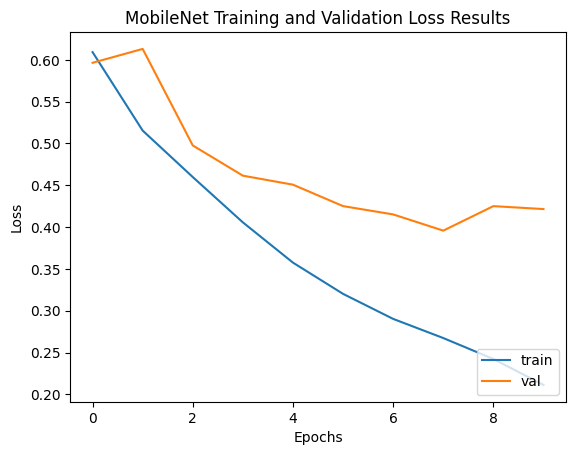

In [16]:
plot(mobile_hist,"MobileNet")

VGG16

In [17]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
# Create a new Sequential model
model = Sequential()

# Add the VGG16 model to the Sequential model
model.add(vgg_model)

# Add a Flatten layer to flatten the output of the VGG16 model
model.add(Flatten())

# Add Dense layers for classification
model.add(GRU(units=64, return_sequences=False))  # Add GRU layer here
model.add(Dense(64, activation='gelu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid')) 

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 32)                802848    
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 15,517,602
Trainable params: 802,914
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
vgghist=model.fit(train_generator,epochs=10,validation_data=val_generator)

Epoch 1/10
536/536 [==============================] - 148s 276ms/step - loss: 0.7022 - accuracy: 0.5062 - val_loss: 0.6931 - val_accuracy: 0.5047
Epoch 2/10
536/536 [==============================] - 132s 246ms/step - loss: 0.6931 - accuracy: 0.5074 - val_loss: 0.6931 - val_accuracy: 0.5047
Epoch 3/10
536/536 [==============================] - 124s 231ms/step - loss: 0.6931 - accuracy: 0.5059 - val_loss: 0.6932 - val_accuracy: 0.5047
Epoch 4/10
536/536 [==============================] - 144s 269ms/step - loss: 0.6931 - accuracy: 0.5074 - val_loss: 0.6931 - val_accuracy: 0.5047
Epoch 5/10
536/536 [==============================] - 136s 253ms/step - loss: 0.6931 - accuracy: 0.5074 - val_loss: 0.6931 - val_accuracy: 0.5047
Epoch 6/10
536/536 [==============================] - 151s 281ms/step - loss: 0.6931 - accuracy: 0.5074 - val_loss: 0.6932 - val_accuracy: 0.5047
Epoch 7/10
536/536 [==============================] - 151s 282ms/step - loss: 0.6931 - accuracy: 0.5074 - val_loss: 0.6931 -

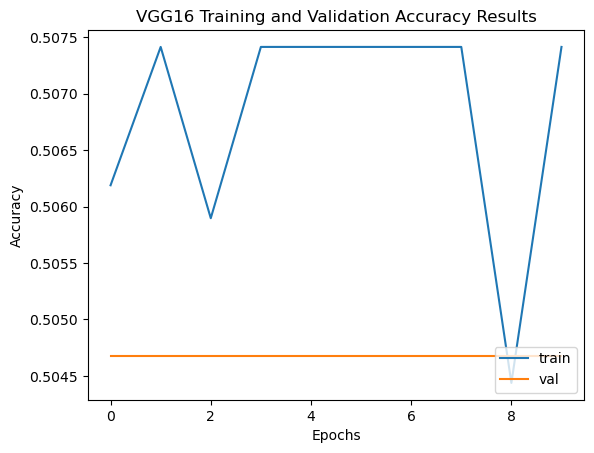

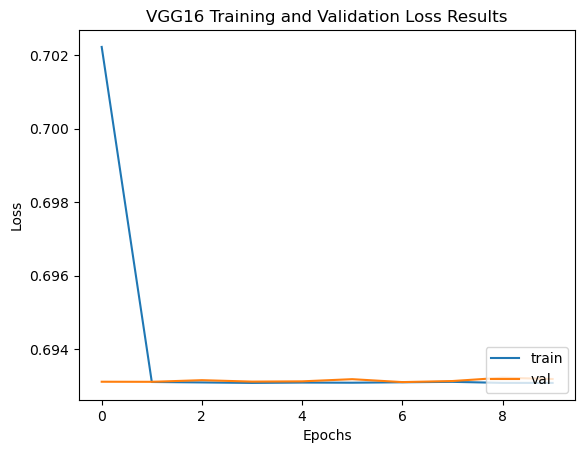

In [22]:
plot(vgghist,"VGG16")

In [26]:
vggpred=model.predict(test_generator)
pred=[]
for i in vggpred:
    if i[0]>=i[1]:
        pred.append(0)
    else:
        pred.append(1)
print(confusion_matrix(testlabels,pred))
print(classification_report(testlabels,pred))

93/93 [==============================] - 18s 195ms/step
[[1529    0]
 [1445    0]]
              precision    recall  f1-score   support

         0.0       0.51      1.00      0.68      1529
         1.0       0.00      0.00      0.00      1445

    accuracy                           0.51      2974
   macro avg       0.26      0.50      0.34      2974
weighted avg       0.26      0.51      0.35      2974



d:\AnaConda\envs\Cap\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\AnaConda\envs\Cap\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\AnaConda\envs\Cap\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ResNet

In [31]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in resnet_model.layers:
    layer.trainable = False
# Create a new Sequential model
model = Sequential()

# Add the VGG16 model to the Sequential model
model.add(resnet_model)

# Add a Flatten layer to flatten the output of the VGG16 model
model.add(GlobalAveragePooling2D())

# Add Dense layers for classification
model.add(GRU(units=64, return_sequences=False))  # Add GRU layer here
model.add(Dense(64, activation='gelu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))  # Assuming 1000 classes for ImageNet

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_8 (Dense)             (None, 32)                65568     
                                                                 
 dense_9 (Dense)             (None, 2)                 66        
                                                                 
Total params: 23,653,346
Trainable params: 65,634
Non-trainable params: 23,587,712
_________________________________________________________________


In [32]:
resnet_hist=model.fit(train_generator,epochs=5,validation_data=val_generator)

Epoch 1/5
536/536 [==============================] - 139s 255ms/step - loss: 0.6976 - accuracy: 0.5091 - val_loss: 0.6901 - val_accuracy: 0.5318
Epoch 2/5
536/536 [==============================] - 131s 244ms/step - loss: 0.6907 - accuracy: 0.5317 - val_loss: 0.6956 - val_accuracy: 0.5019
Epoch 3/5
536/536 [==============================] - 122s 228ms/step - loss: 0.6911 - accuracy: 0.5268 - val_loss: 0.6909 - val_accuracy: 0.5140
Epoch 4/5
536/536 [==============================] - 122s 227ms/step - loss: 0.6890 - accuracy: 0.5338 - val_loss: 0.6897 - val_accuracy: 0.5374
Epoch 5/5
536/536 [==============================] - 123s 229ms/step - loss: 0.6881 - accuracy: 0.5402 - val_loss: 0.6936 - val_accuracy: 0.5271


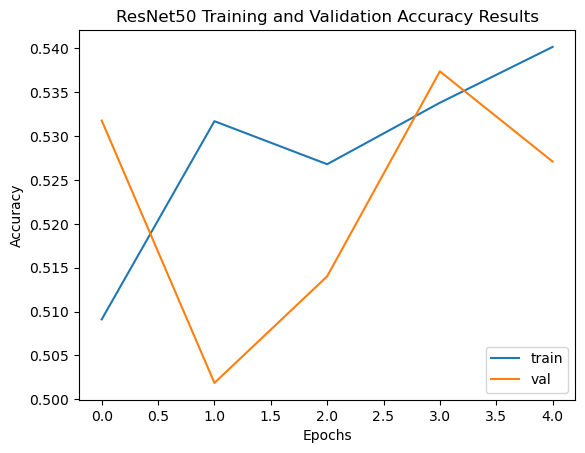

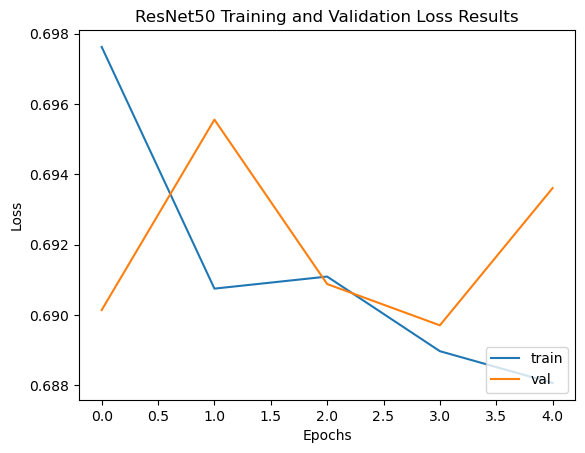

In [33]:
plot(resnet_hist,"ResNet50")

In [34]:
resnet_pred=model.predict(test_generator)

93/93 [==============================] - 20s 209ms/step


In [36]:
pred=[]
for i in resnet_pred:
    if i[0]>=i[1]:
        pred.append(0)
    else:
        pred.append(1)
print(confusion_matrix(testlabels,pred))
print(classification_report(testlabels,pred))

[[1443   86]
 [1278  167]]
              precision    recall  f1-score   support

         0.0       0.53      0.94      0.68      1529
         1.0       0.66      0.12      0.20      1445

    accuracy                           0.54      2974
   macro avg       0.60      0.53      0.44      2974
weighted avg       0.59      0.54      0.44      2974



EfficientNet

In [38]:
base_model = EfficientNetB0(weights='imagenet', include_top=False)

# Create a Sequential model
model = Sequential()

# Add MobileNet base model to the Sequential model
model.add(base_model)

# Add GlobalAveragePooling2D layer to reduce dimensionality
model.add(GlobalAveragePooling2D())

# Add a Dense layer (or more) for classification
model.add(GRU(units=64, return_sequences=False))  # Add GRU layer here
model.add(Dense(64, activation='gelu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))  # num_classes is the number of output classes

# Freeze MobileNet layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 [==============================] - 5s 0us/step


In [41]:
efficientnet_hist=model.fit(train_generator,epochs=5,validation_data=val_generator)

Epoch 1/5
536/536 [==============================] - 152s 282ms/step - loss: 0.6999 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.5056
Epoch 2/5
536/536 [==============================] - 127s 237ms/step - loss: 0.6984 - accuracy: 0.5008 - val_loss: 0.7039 - val_accuracy: 0.4953
Epoch 3/5
536/536 [==============================] - 128s 238ms/step - loss: 0.7028 - accuracy: 0.5011 - val_loss: 0.7173 - val_accuracy: 0.4953
Epoch 4/5
536/536 [==============================] - 135s 252ms/step - loss: 0.7006 - accuracy: 0.5016 - val_loss: 0.6993 - val_accuracy: 0.4953
Epoch 5/5
536/536 [==============================] - 140s 261ms/step - loss: 0.7028 - accuracy: 0.5022 - val_loss: 0.7173 - val_accuracy: 0.4953


In [42]:
efficientnet_pred=model.predict(test_generator)

93/93 [==============================] - 23s 230ms/step


In [43]:
pred=[]
for i in efficientnet_pred:
    if i[0]>=i[1]:
        pred.append(0)
    else:
        pred.append(1)
print(confusion_matrix(testlabels,pred))
print(classification_report(testlabels,pred))

[[   0 1529]
 [   0 1445]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1529
         1.0       0.49      1.00      0.65      1445

    accuracy                           0.49      2974
   macro avg       0.24      0.50      0.33      2974
weighted avg       0.24      0.49      0.32      2974



d:\AnaConda\envs\Cap\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\AnaConda\envs\Cap\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\AnaConda\envs\Cap\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# labels = ("Precision", "Recall", "F1-score","Accuracy")
# models = {
#     'Efficient-Former ViT': (0.87,0.865,0.867,0.877),
#     'EfficientNetB0': (0.24,0.49,0.32,0.49),
#     'VGG16': (0.26,0.51,0.35,0.51),
#     'ResNet50':(0.59,0.54,0.44,0.54),
#     'MobileNetV1':(0.72,0.72,0.72,0.72)
# }

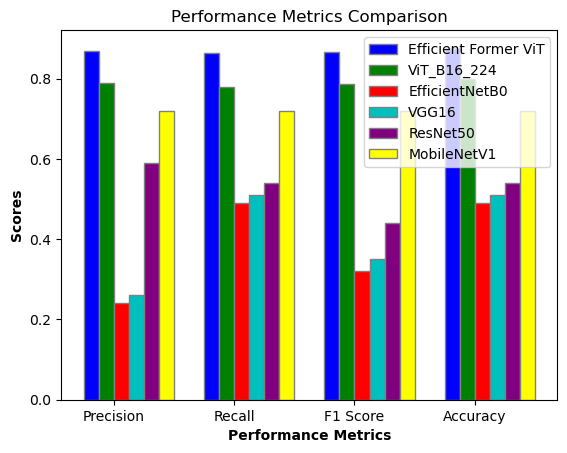

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Define performance metrics
metrics = ['Precision', 'Recall', 'F1 Score', 'Accuracy']

# Define model scores for each performance metric
model1_scores = [0.87,0.865,0.867,0.877]
model2_scores = [0.79,0.78,0.787,0.80]
model3_scores = [0.24,0.49,0.32,0.49]
model4_scores = [0.26,0.51,0.35,0.51]
model5_scores = [0.59,0.54,0.44,0.54]
model6_scores = [0.72,0.72,0.72,0.72]

# Set the width of the bars
bar_width = 0.125
x=5
# Set the positions of the bars on the x-axis
r1 = np.arange(len(metrics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

# Create bar plot
plt.bar(r1, model1_scores, color='b', width=bar_width, edgecolor='grey', label='Efficient Former ViT')
plt.bar(r2, model2_scores, color='g', width=bar_width, edgecolor='grey', label="ViT_B16_224")
plt.bar(r3, model3_scores, color='r', width=bar_width, edgecolor='grey', label='EfficientNetB0')
plt.bar(r4, model4_scores, color='c', width=bar_width, edgecolor='grey', label='VGG16')
plt.bar(r5, model5_scores, color='purple', width=bar_width, edgecolor='grey', label='ResNet50')
plt.bar(r6, model6_scores, color='yellow', width=bar_width, edgecolor='grey', label='MobileNetV1')

# Add xticks
plt.xlabel('Performance Metrics', fontweight='bold')
plt.xticks([r + bar_width*1.5 for r in range(len(metrics))], metrics)

# Add y label
plt.ylabel('Scores', fontweight='bold')

# Add title
plt.title('Performance Metrics Comparison')

# Add legend
plt.legend()

# Show plot
plt.show()